# Errormap

In [12]:
# sélection du cas test
testcase = 1
version = 1
degree = 1
param_num = 1
n_params = 1

In [ ]:
assert testcase in [1,2]
if testcase == 1:
    assert version in [1,2,3]
else:
    assert version == 1

**Idée :** On se place ici dans un des cas tests proposés : TestCase1,1_v2,2.

On cherche à afficher des cartes d'erreur sur la solution.

## Imports + Load

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import dolfin as df
import seaborn as sns

# from modules.fenics_expressions import UexExpr
from scimba.equations.domain import SpaceTensor
from scimba.equations import domain

from modules.utils import create_tree
# from modules.geometry import Square
from modules.fenics_expressions import UexExpr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
if testcase == 1:
    if version == 1:
        from modules.testcases.d2.test_1.test_1_v1 import Run_laplacian2D,Poisson_2D
    elif version == 2:
        from modules.testcases.d2.test_1.test_1_v2 import Run_laplacian2D,Poisson_2D
    else:
        raise ValueError("Version not found")
    from modules.problem import TestCase1
    problem = TestCase1()
elif testcase == 2:
    from modules.testcases.d2.test_2.test_2_v1 import Run_laplacian2D,Poisson_2D
    from modules.problem import TestCase2
    problem = TestCase2()
else:
    raise ValueError("Testcase not found")
from modules.solver_fem_1_2 import FEMSolver


dim_params = problem.nb_parameters
result_dir = "../../../results/2D/testcase"+str(testcase)+"/version"+str(version)
result_dir += "/errormap/"
create_tree(result_dir)

tab_nb_vert = [20,40]
tab_h = []
for nb_vert in tab_nb_vert:
    solver = FEMSolver(nb_cell=nb_vert-1, params=[[]], problem=problem, degree=degree)
    tab_h.append(np.round(solver.mesh.hmax(),2))

hmax =  0.23383594411359887
hmax =  0.11392007533739443


/home/flecourtier/Bureau/Article1
>> load network /home/flecourtier/Bureau/Article1/networks/test_fe1.pth
jsbdbshd
network loaded


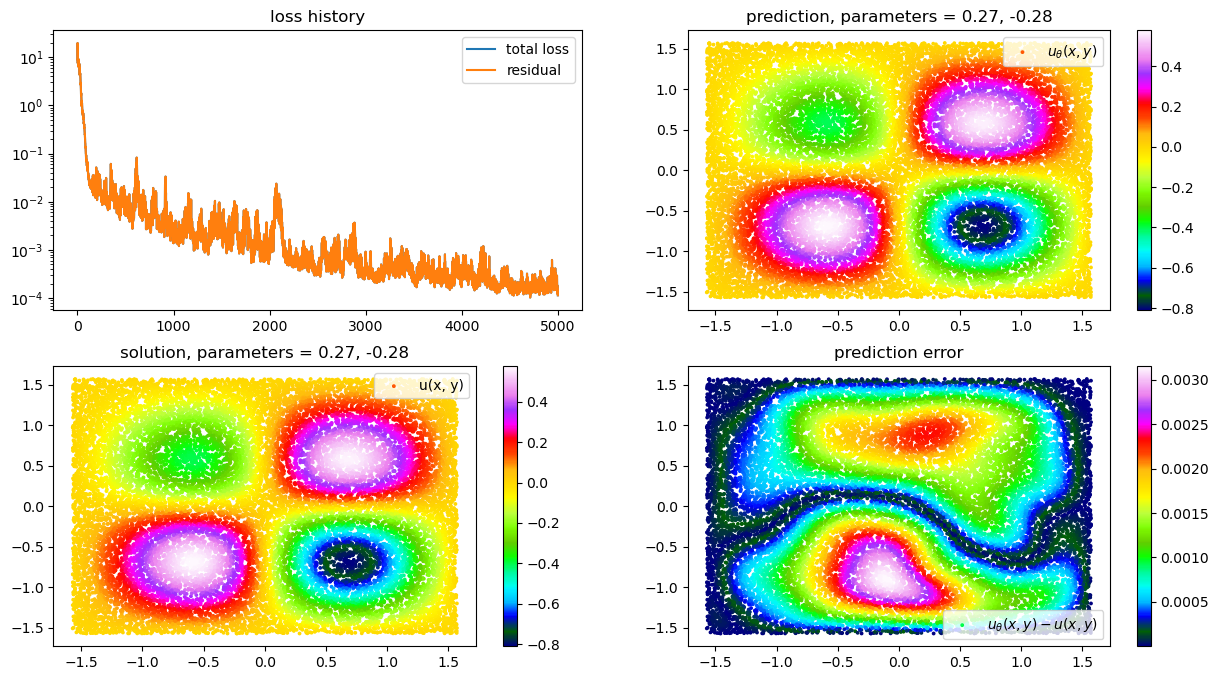

In [16]:
pde = Poisson_2D()
trainer,u_theta = Run_laplacian2D(pde)

In [17]:
def get_param(i):
    params = trainer.pde.parameter_domain.cpu().numpy()
    # pick 1 random parameter
    np.random.seed(0)
    for j in range(i):
        param = [np.random.uniform(params[0][0], params[0][1]), np.random.uniform(params[1][0], params[1][1])]
    param = np.round(param, 2)
    return param

params = np.array([get_param(param_num)])
params_str = np.array([f"{params[i][0].round(2)},{params[i][1].round(2)}" for i in range(n_params)])
params


array([[0.05, 0.22]])

## Erreurs PINNs

In [18]:
def get_test_sample(i,solver,trainer,deg_PINNs):
    # get coordinates of the dof
    V_test = df.FunctionSpace(solver.mesh,"CG",deg_PINNs)
    XXYY = V_test.tabulate_dof_coordinates()
    X_test = torch.tensor(XXYY,requires_grad=True)
    X_test = SpaceTensor(X_test,torch.zeros_like(X_test,dtype=int))

    # get parameters
    nb_params = len(trainer.pde.parameter_domain)
    shape = (XXYY.shape[0],nb_params)
    ones = torch.ones(shape)
    mu_test = (torch.Tensor(params[i]).to(device) * ones).to(device)

    return V_test,X_test,mu_test

In [23]:
def read_csv_PINNs(testcase,degree):
    df_PINNs = pd.read_csv(result_dir+f'PINNs_case{testcase}_degree{degree}.csv')
    tab_err_PINNs = df_PINNs.values[2:,1:]
    
    return tab_err_PINNs

def run_PINNs(degree,new_run=False):
    csv_file = result_dir+f'PINNs_case{testcase}_degree{degree}.csv'
    col_names = [("PINNs",str(tab_nb_vert[i]),tab_h[i]) for i in range(len(tab_nb_vert))]
    mi = pd.MultiIndex.from_tuples(col_names, names=["method","n_vert","h"])
    if not new_run and os.path.exists(csv_file):
        tab_err_PINNs = read_csv_PINNs(testcase,degree)
        df_PINNs = pd.DataFrame(tab_err_PINNs,columns=mi)
        print(f"Read csv file {csv_file}")
    else:
        colormap = "jet"
        tab_err_PINNs = np.zeros((n_params,len(tab_nb_vert)))

        for (j,nb_vert) in enumerate(tab_nb_vert):
            print(f"nb_vert={nb_vert}")
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)
            degree_PINNs = solver.high_degree
            print("param =",end=" ")
            for i in range(n_params):
                print(i,end=" ")
                V_test,X_test,mu_test = get_test_sample(i,solver,trainer,degree_PINNs)
                pred = u_theta.setup_w_dict(X_test, mu_test)
                phi_tild = pred["w"][:,0].cpu().detach().numpy()
                
                u_PINNs = df.Function(V_test)
                u_PINNs.vector()[:] = phi_tild.copy()

                u_ex = UexExpr(params[i], degree=solver.high_degree, domain=solver.mesh, pb_considered=solver.pb_considered)
                
                uref_Vex = df.interpolate(u_ex,V_test)
                norme_L2 = (df.assemble((((uref_Vex - u_PINNs)) ** 2) * solver.dx) ** (0.5)) / (df.assemble((((uref_Vex)) ** 2) * solver.dx) ** (0.5))
            
                plt.figure(figsize=(15,5))
                
                plt.subplot(1,3,1)
                c = df.plot(uref_Vex,cmap=colormap)
                plt.colorbar(c)
                plt.title("uref")
                
                plt.subplot(1,3,2)
                c = df.plot(u_PINNs,cmap=colormap)
                plt.colorbar(c)
                plt.title("uPINNs")
                
                plt.subplot(1,3,3)
                error = df.Function(solver.V_ex)
                error.vector()[:] = uref_Vex.vector()[:] - u_PINNs.vector()[:]
                c = df.plot(error,cmap=colormap)
                plt.colorbar(c)
                plt.title("error {0:.2e}".format(norme_L2))
                
                plt.suptitle(f"nb_vert={nb_vert} param ({i})={params_str[i]}")
                plt.savefig(result_dir+f"errormap_{i}_N{nb_vert}.png")
                plt.show()
                tab_err_PINNs[i,j] = norme_L2
            print()

        
        df_PINNs = pd.DataFrame(tab_err_PINNs,columns=mi)
        df_PINNs.to_csv(csv_file)
        
    return df_PINNs, tab_err_PINNs

nb_vert=20
hmax =  0.23383594411359887
param = 0 

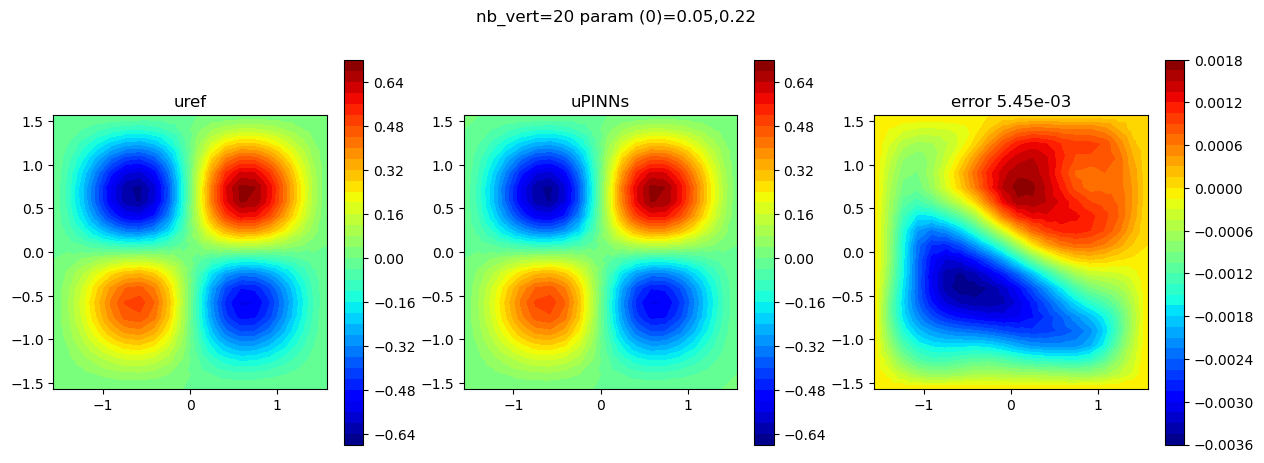


nb_vert=40
hmax =  0.11392007533739443
param = 0 

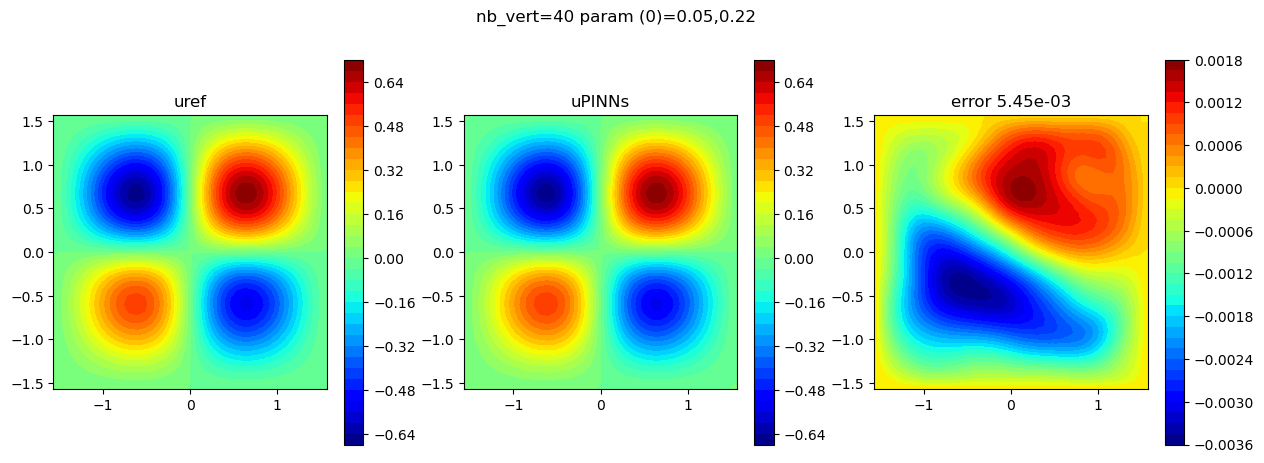

In [24]:
df_PINNs, tab_err_PINNs = run_PINNs(degree,new_run=True)